In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import additional_code as code
import warnings
from pylj import md, sample, force, examples, util, em
warnings.filterwarnings('ignore')

# ISIS Neutron Training Course
## Computational Simulation for Neutron Scattering

#### Andrew R. McCluskey 
##### University of Bath/Diamond Light Source - arm61@bath.ac.uk

2018-03-08

>The speed and development of computers is now so rapid, and the advances in modelling and informatics are so dramatic that is 15 years' time no chemist will be doing an experiments at the bench without trying to model them first.

> **Prof. Dominic Tildesley, Former RSC President, 2013**

### Introduction 

Molecular dynamics simulation is a common and powerful technique in computational chemistry/statistical physics for the determination of equilibrium & transport properties of many-body systems. These systems consist of particles interacting through force-fields, whose motions are described by classical Newtonian mechanics, for molecular dynamics this comes down to two equations,

$$ \mathbf{r}(t+\Delta t) = \mathbf{r}(t) + \mathbf{v}(t)\Delta t + \dfrac{1}{2} \mathbf{a}(t)\Delta t^2, $$

where, $\mathbf{r}(t)$ is the position, $\mathbf{v}(t)$ is the velocity, and $\mathbf{a}(t)$ is the acceleration of the particle at a given time $t$, while $\mathbf{r}(t+\Delta t)$ is the position after the timestep, $\Delta t$, and, 

$$ \mathbf{f}(t) = m\mathbf{a}(t), $$

where $\mathbf{f}(t)$ is the force on some particle at time $t$, and $m$ is the particle mass.

Generally speaking the use of classical mechanics compared to quantum mechanics is a very good approximation for many molecular materials, where quantum mechanical effects are weak -- these only become significant for very light atoms, e.g. $\text{H}_2$ or $\text{He}_2$ molecules. 

A molecular dynamics simulation can be considered in a similar way to a real experiment. A general recipe for a real experiment would be: 

1. Prepare the sample -- buy the constituent chemicals and mix them approporiately to get your single crystal of a photovoltaic material, grow and purify the protein in deuterared medium, etc. 
2. Allow the sample to interact with some measuring instrument -- fly to the ILL and put the sample on D9, bring it to ISIS and put it on SANS2D.
3. Finally, measure some property of the sample for a given time -- collect the diffraction, or SANS pattern until the counting is good. 

A similar recipe can be applied to a molecular dynamics simulation:

1. Prepare the sample -- build the particle coordinates, determine a suitable force-field and equilibriate the sample by solving Newton's equations of motion until some property of the system no longer changes beyond random fluctuations.
2. Allow the sample to interact with some measuring instrument -- within molecular dynamics this involves determining a quantity that can be measured as a function of the positions, velocities, and accelerations of the particles. 
3. Finally, measure that property of the sample for a given time -- this means calculating Newton's equations of motion iteratively, for a long enough time that good statistics can be obtained of the measurement quantity. 

It is important to be aware that this means that the problems present in real experiments are possible in molecular dynamics simulations; preparing the sample incorrectly by using an inaccurate force field, or measuring for too short a time. 

For using molecular dynamics simulation to understand neutron scattering, the property that is being measured in the simulation should be as similar as possible to that measured in the neutron experiment. For example, small angle neutron scattering (SANS) measured the position of clusters of atoms with respect to each other, therefore to determine a SANS profile from molecular simulation we must sample the atomic coordinates during the molecular dynamics simulation. 

### Force-fields 

In molecular dynamics, the electrons are not explicitly simulated, instead the system is modelled as a series of point particles that interact based on some *force-field*. The force-field is a function that describes the potential energy, $u$, for a given configuration of the system, typically for a molecular system this consists of bonded and non-bonded components, 

$$ u = u_{\text{bonded}} + u_{\text{non-bonded}} $$

The potential energy depends on the functions used, their parameterisation and the configuration of the system at a given time. The functions and their parameterisation depend on the underlying chemistry of the system, the particular functions that are described herein are those associated with the OPLS2005 force field.[1]

#### Non-bonded interactions 

In the OPLS2005 force-field, two forms of non-bonded interaction are present, van der Waals and Coulombic. The van der Waals interaction is modelled with a Lennard-Jones potential, and has the following form, 

$$ u_{\text{vdW}} = 4\epsilon_{ij}\Bigg[\bigg(\frac{\sigma_{ij}}{\mathbf{r}_{ij}}\bigg)^{12} - \bigg(\frac{\sigma_{ij}}{\mathbf{r}_{ij}}\bigg)^6\Bigg], $$

where, $\epsilon_{ij}$ and $\sigma_{ij}$ are parameters specific to the interaction, hence the atom types, such that the van der Waals interaction vaires with distance between atoms, $\mathbf{r}_{ij}$. The Coulombic interaction is that between ions, modelled with a Coulombic potential, 

$$ u_{\text{Coulombic}} = \frac{q_iq_j}{4\pi\epsilon\mathbf{r}_{ij}} $$

where, $q_i$ and $q_j$ are the charges on the interacting particles -- it should be noted that the charge does not need to be an integer essentially allowing for the presense of polarity, and $\epsilon$ is the permittivity of the solvent. The Lennard-Jones, Coulombic, and total non-bonded potentials for a sodium-chloride ion pair are determined an shown below. 

In [ ]:
sigma_ij = 3.7552
epsilon_ij = 0.0756

r = np.arange(0.01, 10.01, 0.01)

u_vdW = 4. * epsilon_ij * ((sigma_ij / r) ** 12 - (sigma_ij / r) ** 6)
u_Coulombic = (-1 * 1) / (4. * np.pi * r)  / (1.036E-2) # The division is to correct the units
u = u_vdW + u_Coulombic


fig, ax = code.nonbond_plots()
ax.plot(r, u_vdW, label=r'$u_{vdW}$')
ax.plot(r, u_Coulombic, label=r'$u_{Coulombic}$')
ax.plot(r, u, label=r'$u$')
plt.legend() 
plt.show()

#### Bonded interactions

The bonded interactions describe the nature of the models used to form chemical bond between particles. In the OPLS2005 force-field, these generally consist of bond stretchs, angle bends, and dihedral flexes; with the functional forms, 

$$ \begin{array} 
Uu_{\text{bonded}} & = \sum_{\text{bonds}}K_b(b-b_0)^2 + \sum_{\text{angles}} K_\theta(\theta - \theta_0)^2 \\
 & = \sum_{\text{dihedrals}}\dfrac{1}{2}\Big\{A_1\big(1 + \cos{[\phi]}\big)+A_2\big(1-\cos{[2\phi]}\big) + A_3\big(1+\cos{[3\phi]}\big)\Big\}\end{array}$$
 
where $K_b$, $b_0$, $K_\theta$, $\theta_0$, $A_1$, $A_2$, and $A_3$ are potential model dependent parameters for the bonds, angles, and dihedrals respectively, while $b$, $\theta$, and $\phi$ are the bond length and siize of the angles and dihedrals in the system. It can be seen that both the bond and angle interactions are modeled with harmonic functions, while the dihedral angle interaction consists of a series of cosines. The form of each of these potentials for a chain of carbon atoms are shown below. 

In [ ]:
fig, ax = code.bond_plots()

K_b = 1121.3
b_0 = 1.529

b = np.arange(1, 2, 0.001)
u_b = K_b * (b - b_0) ** 2

ax[0].plot(b, u_b)

K_theta = 244.1
theta_0 = 112.7

theta = np.arange(110, 120, 0.001)
u_theta = K_theta * (theta - theta_0) ** 2

ax[1].plot(theta, u_theta)

A1 = 1.135
A2 = -0.151
A3 = 0.400

phi = np.arange(0, 360, 0.01)
u_phi = 0.5 * (A1 * np.cos(np.deg2rad(phi)) + A2 * np.cos(np.deg2rad(2*phi)) + A3* np.cos(np.deg2rad(3*phi)))

ax[2].plot(phi, u_phi)

plt.tight_layout()
plt.show()

### Off-the-shelf force-fields

Many "off-the-shelf"force-fields exist, which have been parametrised, from experimental data or quantum calculations. These should be used with caution, as the application of an off-the-shelf force-field can lead to poor agreement with experimental data, if the new system is significantly different from those used in the parameterisation process -- generally the off-the-shelf force-field should be used to reproduce some simple experiment parameters before use, e.g. density. Common off-the-shelf force-fields include: 
- OPLS2005/OPLS-AA -- this is the Optimised Potential for Liquid Simulations, a general purpose force-field for the simulation of liquid systems (OPLS2005 is an update to OPLS-AA). 
- CHARMM -- Chemistry at HARvard Molecular Mechanics, widely used for small molecules and proteins. 
- GROMOS -- the GROningen MOlecular Simulation comes with the GROMOS/GROMACS software, particularly useful for biomolecules. 
- AMBER -- the Assisted Model Building and Energy Refinement, again popular for proteins and DNA. 
- MARTINI -- this is a coarse-grained force field where each 4 heavy atoms ($Z > 1$) is represented with one coarse-grained "bead", parameterisation to reproduce lipid and protein interactions. 
- Many, many others for many types of application. 

### Periodic boundary conditions

The purpose of molecular simulation for neutron scattering is to reproduce the properties of some experimental system. However, current computational systems cannot efficiently model such large systems -- limited to about 10s of millions of particles ($1\times10^{-17}$ moles).[2] Therefore simplications must be made; the most routinely applied is that of the periodic box. This is where a boundary condition is applied to the edges of the simulation box to mimic an infinite system -- by creating the situation that the simulation box is surrounded by infinite identical images of itself.[3] This is achieved by having a particle that reaches the edge of the simulation box appear on the other side of the box; as though it came in from the adjecent periodic image. Additionally, when the force is calculated on each particle, the periodic nature is considered and if particles are more than half of the box apart, it is recognised that they are closer by replacing one of the particles with that from the adjacent periodic image. This shorter distance is then used in the force calculation.

Below is an interactive example that shows a single particle that has been given some initial velocity in a random direction. It will travel across the periodic boundary of the simulation box appearing on the other side. The first number (initially 5000) is the number of steps in the simulation, while the second number (initially 1) is the initial kinetic energy given to the particle. 

<IPython.core.display.Javascript object>


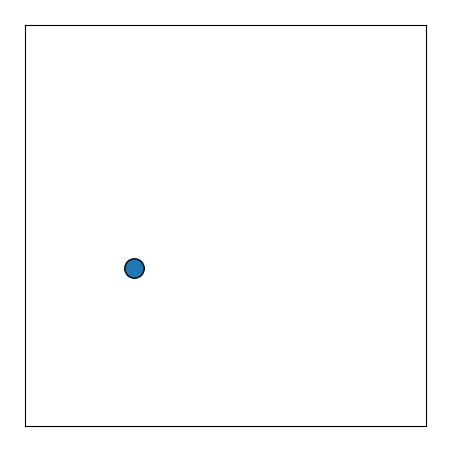

In [2]:
examples.periodic_boundary(5000, 1)

### A molecular dynamics program

One of the best ways to understand how a molecular dynamics simulation works is to consider how a molecular dynamics program would work. Below is an example of a molecular dynamics simulation, of Lennard-Jones particles interacting in a 2D simulation box. The property we are sampling is the radial distribution function of each particle. 

In [ ]:
# Assigning some parameters
number_of_particles = 370
temperature = 1.
number_of_steps = 1000
sample_frequency = 10
timestep_length = 0.01

# Initialise the system
particles, system = md.initialise(number_of_particles, temperature, timestep_length, util.set_particles_square)
# This sets the sampling object
sample_system = sample.RDF(system)
# Start at time 0
system.time = 0
# Begin the molecular dynamics loop
for i in range(0, number_of_steps):
    # At each step, calculate the forces on each particle 
    # and get acceleration
    particles, system = force.compute_forces(particles, system)
    # Run the equations of motion integrator algorithm
    particles, system = md.velocity_verlet(particles, system)
    # Allow the system to interate with a heat bath
    particles = force.heat_bath(particles, system)
    # Iterate the time
    system.time += system.timestep_length
    # At a given frequency sample the positions and plot the RDF
    if system.step % sample_frequency == 0:
        sample_system.update(particles, system)
# Once the simulation is complete get average RDF
sample_system.average_rdf()

#### Initialisation

The initialisation process involves getting the starting positions and velocities for the particles in the system. Generally speaking the initial positions are system dependent and can be obtained from a source or generated using appropriate software. For example, the simulations of proteins often involves taking a starting structure from the Protein Data Bank [4] crystallographic information, this requires a crystal structure of the protein to have been resolved. Other methods would include generating energy minimised structures *in-silico*, e.g. with Jmol, [5] and orienting the structures appropriately using a program such as Packmol. [6]

In [ ]:
import nglview
# this downloads the lysozyme pdb file and presents it
view = nglview.show_pdbid("253L")
view

In the above 2D example the initial positions were generated by placing the particles on a square lattice, however the particles could also be placed in random positions. 

<IPython.core.display.Javascript object>


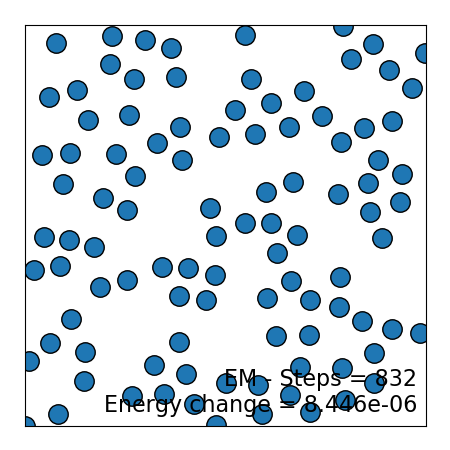

In [3]:
# Assigning some parameters
number_of_particles = 100 
temperature = 1

# Initialise the system with random positions
particles, system = em.initialise(number_of_particles, util.set_particles_random, 1e-5, 1e3)
# This sets the sampling object
sample_system = sample.JustCell(system)
sample_system.update(particles, system, '')

However, this may be problematic as it can be seen that many particles are very close together and overlapping. Therefore it may be necessary to perform an energy minimisation before starting the molecular dynamics simulation, to ensure that the simulation does not "explode". Below shows a steepest descent energy minimsation algorithm in action.

In [4]:
alpha = 0.01

# Steepest decent
particles = em.steepest_descent(particles, system, sample_system, alpha)

The generation of initial velocities is a more general process than the positions. The velocities are randomly selected from a uniform distribution, $\mathbf{v}_i(0) \in [-0.5, 0.5]$, it is necessary to then shift them such as to obtain a total momentum of zero. The velocites are also scaled by a factor, that includes the simulation temperature, $T$.

$$ \mathbf{v}_i(0) = \sqrt{2 T}\times\cos\big[2\pi \mathbf{v}_i(0)\big]. $$

There is no need to intitialise the velocites with a Maxwell-Boltzmann distribution as this will happen naturally within the simulation. 

In [ ]:
v_i = np.random.uniform(-0.5, 0.5, 10000)
temperature = 1.
fig, ax = code.velocity_plot()
v_i = (v_i - np.average(v_i)) * np.sqrt(3 * temperature / (np.average(v_i) ** 2.))
ax.hist(v_i, histtype='step', lw=2)
plt.show()

The final step of the initialisation process is to determine the particle positions before the first timestep, e.g. at $t = -\Delta t$. This can be achieved using the following relation, 

$$ \mathbf{r}_i(-\Delta t) = \mathbf{r}_i(0) - \mathbf{v}_i(0)\Delta t. $$

Having initialised both the positions and velocites we can now start the iterative procedure of the molecular dynamics simulation.

#### Force calculations

The calculation of the forces on each of the atoms is the most computationally time consuming part of a molecular dynamics simulation. This is due to the fact that we must consider the pairwise interactions over all of the particles in our system -- this means calculating the force for $\frac{(N^2 - N)}{2}$ pairs. This results in the speed of the algorithm associated with the force calculation scale as order $N^2$ meaning that quite quickly the simulation can become size limited. 

The force on a particle is equal to the negative of the gradient of the potential energy for a given system configuration, this means that the force is found from the first derivative of the potential energy function, 

$$ \mathbf{f} = -\frac{\delta u}{\delta \chi} $$

where, $\mathbf{f}$ is the force on the particle, $u$ is the particle potential energy -- from the force-field, and $\chi$ is the current configuration of the particle. This calculation is achieved by finding the distance in the $x$, $y$, and $z$ dimensions for every pair of particles, $i$ and $j$. If the particles are further apart in a particular direction than half the length of the simulation box in that dimension the periodic boundary correction is applied; where one of the particles is swapped with that from an adjacent image, such that the particles are closer together. At this stage, the system cut-off is also applied, this is where if the particles are beyond a certain distance apart, the force that they apply on each other is considered to be effectively zero so the energy and force are not calculated -- this is a method of improving the speed of the force calculation. 

In [ ]:
# Assigning some parameters
number_of_particles = 4
temperature = 1
timestep_length = 0.01

# Initialise the system with random positions
particles, system = em.initialise(number_of_particles, util.set_particles_random, 1, 1e3)
# It is necessary to perform an energy minimsation to stop particle overlap
particles = em.steepest_descent(particles, system, None, 0.01)
# This object allows for the visualisation 
sample_system = sample.ShowForce(system)
sample_system.update(particles, system)
particles, system = md.initialise_from_em(particles, system, temperature, timestep_length)
for i in range(0, number_of_particles-1):
    for j in range(i+1, number_of_particles):
        dx = particles[i].xpos - particles[j].xpos
        dy = particles[i].ypos - particles[j].ypos
        if np.abs(dx) > 0.5 * system.box_length:
            dx = dx * (1 - system.box_length / np.abs(dx))
        if np.abs(dy) > 0.5 * system.box_length:
            dy = dy * (1 - system.box_length / np.abs(dy))
        dr = np.sqrt(dx * dx + dy * dy)
        f = 48. * dr ** -13. - 24. * dr * -7.
        x_force = f * dx / dr
        y_force = f * dy / dr
        sample_system.draw_force(particles, i, j, x_force, y_force)
sample_system.clear_force()

#### Equations of motion integration 

Due to the fact that the potential energy is a function of the entire system configuration ($3N$ in 3-dimensions), Newton's equations of motion are no longer analytically solvable -- instead an approximate Newtonian integrator must be used. Many different integrators exist, the most common come from the Velocity family, the simplest of which is the Verlet algorithm, 

$$ \mathbf{r}_i(t+\Delta t)\approx 2\mathbf{r}_i(t) - \mathbf{r}_i(t-\Delta t) + \dfrac{\mathbf{f}_i(t)}{m_i}\Delta t^2 $$

where, $\mathbf{r}(t+\Delta t)$ is the new particle position, $\mathbf{r}(t)$ is the current particle position, $\mathbf{r}(t-\Delta t)$ is the previous particle position, $\mathbf{f}(t)$ is the force calculated in the current step, and $m$ is the particle mass. 

This algorithm does not compete the velocity explicitly; calculation of the kinetic energy requires the velocity, $\mathbf{v}(t)$, therefore it can be found from knowledge of the trajectory, 

$$ \mathbf{v}_i(t) = \dfrac{\mathbf{r}_i(t+\Delta t) - \mathbf{r}_i(t - \Delta t)}{2 \Delta t}. $$

The kinetic energy -- therefore velocity, is used to find the instantaneous temperature, $T_{\text{inst}}$, of the system, this is important in the constant temperature ensembles, 

$$ T_{\text{inst}} = \dfrac{\sum_{i=1}^{N} \mathbf{v}_i(t)}{3N} $$

In [ ]:
# Assigning some parameters
number_of_particles = 100
temperature = 5.
number_of_steps = 1000
timestep_length = 0.01

# Initialise the system with random positions
particles, system = em.initialise(number_of_particles, util.set_particles_random, 1e-5, 1e3)
# This sets the sampling object
sample_system = sample.Temperature(system)
system.temp_array = [temperature]
sample_system.update(particles, system, 'EM')
# It is necessary to perform an energy minimsation to stop particle overlap
particles = em.steepest_descent(particles, system, sample_system, 0.01)
particles, system = md.initialise_from_em(particles, system, temperature, timestep_length)
for j in range(0, number_of_particles):
    particles[j].xpos_prev = particles[j].xpos - particles[j].xvel * system.timestep_length
    particles[j].ypos_prev = particles[j].ypos - particles[j].yvel * system.timestep_length
for i in range(0, number_of_steps):
    forces = force.get_forces(particles, system)
    T = 0. 
    for j in range(0, number_of_particles):
        position_store = [particles[j].xpos, particles[j].ypos]
        particles[j].xpos = 2 * particles[j].xpos - particles[j].xpos_prev + forces[0][j] * system.timestep_length ** 2
        particles[j].ypos = 2 * particles[j].ypos - particles[j].ypos_prev + forces[1][j] * system.timestep_length ** 2 
        particles[j].xpos = particles[j].xpos % system.box_length
        particles[j].ypos = particles[j].ypos % system.box_length
        particles[j].xvel = (particles[j].xpos - particles[j].xpos_prev) / (2 * system.timestep_length)
        particles[j].yvel = (particles[j].ypos - particles[j].ypos_prev) / (2 * system.timestep_length)        
        particles[j].xpos_prev = position_store[0]
        particles[j].ypos_prev = position_store[1]
        T += np.sqrt(particles[j].xvel * particles[j].xvel + particles[j].yvel * particles[j].yvel)
    system.temp_array.append(np.sum(T) / (3 * system.number_of_particles))
    sample_system.update(particles, system, 'MD')

Following the integration, the system configuration is sampled for some desired information at a given frequency. 

Within molecular dynamics, one of the significant limitations is the size of the time-step, $\Delta t$. Generally speaking the time-step should be less than the highest frequency vibration in the system to ensure that the force-field is modelling the system accurately. For simulations containing explicitly modelled hydrogen atoms, the time-step should be 1 fs as a maximum. Larger time-steps can be accessed using coarse-grained force-fields such as MARTINI, or by fixing the positions of the hydrogen atoms with respect to the heavy atom to which it is bound.

#### Ensembles 

The molecular dynamics simulation that is discussed above was in the NVE ensemble, where the number of particles (N), volume of the simulation box (V), and energy of the system (E) are held constant. Other ensembles exist, such as the NVT ensemble, where T indicates constant temperature, or NPT, constant pressure (P). 

In an NVT simulation, the simulation is coupled with a heat bath at a given temperature, for the Anderson thermostat, the simulation algorithm is modified as follows:

1. The initial set of positions and velocities of the particles are generated as normal.
2. After the first step, $\Delta t$, a number of particles are selected to undergo a collision with a heat bath. The probability that a particle is selected depends on some coupling frequency.
3. If particle $i$ is selected to undergo a collision, a new velocity is selected from a Maxwell-Boltzmann distribution corresponding to the desired temperature, $T$. 

This allows the system to stay approximately equal to the defined temperature, with random fluctuations in the instanteous pressure. The below simulation shows the effect of the heat bath within the Velocity Verlet algorithm. 

In [ ]:
# Assigning some parameters
number_of_particles = 200
temperature = 1.
number_of_steps = 1000
sample_frequency = 10
timestep_length = 0.01

# Initialise the system
particles, system = md.initialise(number_of_particles, temperature, timestep_length, util.set_particles_square)
# This sets the sampling object
sample_system = sample.Interactions(system)
# Start at time 0
system.time = 0
# Begin the molecular dynamics loop
for i in range(0, number_of_steps):
    # At each step, calculate the forces on each particle 
    # and get acceleration
    particles, system = force.compute_forces(particles, system)
    # Run the equations of motion integrator algorithm
    particles, system = md.velocity_verlet(particles, system)
    # Allow the system to interate with a heat bath
    particles = force.heat_bath(particles, system)
    # Iterate the time
    system.time += system.timestep_length
    # At a given frequency sample the positions and plot the RDF
    if system.step % sample_frequency == 0:
        sample_system.update(particles, system)
# Once the simulation is complete get average RDF
sample_system.average_rdf()

#### Molecular dynamics simulation packages

Similar to the number of force-fields, there are also a wide range of molecular dynamics software packages available -- the choice of software can depend on personal preference and what is being simulated. Common molecular dynamics software include:

- LAMMPS -- possible the most common molecular dynamics package due to the flexibility offered, popular amoung hardcore theoreticians.
- NAMD -- popular package from the USA for the simulation of biological systems in particular.
- GROMACS -- effectively the European challenger to NAMD, popular for coarse-grained simulation due to the inclusion of the MARTINI force-field. 
- DL_POLY -- developed through CCP5-EPSRC funding, popular for the development of force-fields. 

### Application to neutron scattering

Shown below is a molecular dynamics simulation, from which the neutron scattering/diffraction profile is being determined. The scattering is found from a Fourier transform of the radial distribution function, however could also be found by the Debye relation. 

$$ I(q) = \sum_j^N \sum_k^N b_jb_k \frac{sin(q|\mathbf{r}_j - \mathbf{r}_k|)}{q|\mathbf{r}_j - \mathbf{r}_k|}, $$

where $b_j$ and $b_k$ are the scattering length densities of particles $j$ and $k$, $\mathbf{r}_j$ and $\mathbf{r}_k$ are the positions of particles $j$ and $k$, $q$ is the scattering vector, and $I(q)$ is the determined intensity. By varying the number of particles investigate how the scattered intensity, and radial distribution function change (try 100, 200, and 380 particles). 

<IPython.core.display.Javascript object>


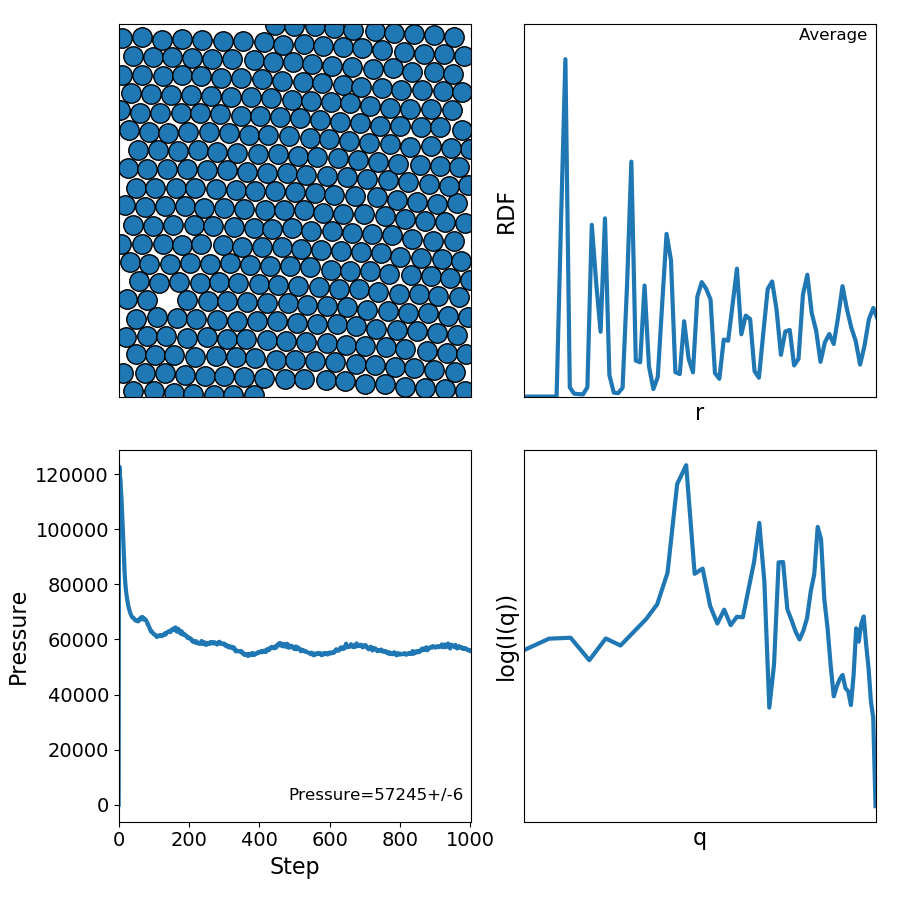

In [2]:
# Assigning some parameters
number_of_particles = 350
temperature = 1.
number_of_steps = 1000
sample_frequency = 10
timestep_length = 0.01

# Initialise the system
particles, system = md.initialise(number_of_particles, temperature, timestep_length, util.set_particles_square)
# This sets the sampling object
sample_system = sample.Scattering(system)
# Start at time 0
system.time = 0
# Begin the molecular 



#dynamics loop
for i in range(0, number_of_steps):
    # At each step, calculate the forces on each particle 
    # and get acceleration
    particles, system = force.compute_forces(particles, system)
    # Run the equations of motion integrator algorithm
    particles, system = md.velocity_verlet(particles, system)
    # Allow the system to interate with a heat bath
    particles = force.heat_bath(particles, system)
    # Iterate the time
    system.time += system.timestep_length
    # At a given frequency sample the positions and plot the RDF
    if system.step % sample_frequency == 0:
        sample_system.update(particles, system)
# Once the simulation is complete get average RDF and scattering profile
sample_system.average()

1. J. L. Banks, *et al.* , *J. Comput. Chem.*, 2005, **26**, 1752–1780.
2. K. Y. Sanbonmatsu and C. S. Tung, *J. Struct. Biol*, 2007, **157**, 470-480.
3. D. Frenkel and B. Smit, *Understanding Molecular Simulation: From Algorithms to Applications*, Academic Press, San Diego, USA, 2nd Edn., 2002. 
4. *RCSB Protein Data Bank -- RCSB PDB*, http://www.rscb.org/pdb/home/home.do, Accessed 2017-03-02.
5. *Jmol: an open-source Java viewer for chemical in 3D*, http://www.jmol.org/, Accessed: 2017-03-02.
6. L. Martínez, *et al.*, *J. Comput. Chem*, 2009, **30**, 2157-2164.